## Machine Learning Breast Cancer Detection

Breast cancer is one of the most common cancer in the world. IDC is one of the representative breast cancer(80% breast cancer is IDC). So, detect if the breast cancer is IDC can be one of the most important method to justify breast cancer.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import itertools

import sklearn
from sklearn import model_selection

# model_selection is used to split our data into train and test sets

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold, learning_curve, GridSearchCV

# sklearn. metrics module implements several loss, score, and utility functions to measure classification performance
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.utils import to_categorical

# Importing sequential api and layers
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D
# Maxpooling layer
from tensorflow.keras.layers import MaxPooling2D

# RandomForestClassifier and Gradient Boosting Classifer for ensemble Ml
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
# For Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

import warnings
# warnings.filterwarnings("ignore")

### 2. Data analysis

Shuffle original datasets

In [2]:
# Loading the image data (X) and labels (Y)
X = np.load('data/X_half_stratified.npy')  # Images
Y = np.load('data/Y_half_stratified.npy')  # Labels (0 = not IDC, 1 = IDC)


Also shuffle the label

In [3]:
# Shuffle the data to ensure random distribution
from sklearn.utils import shuffle
X,Y = shuffle(X,Y)

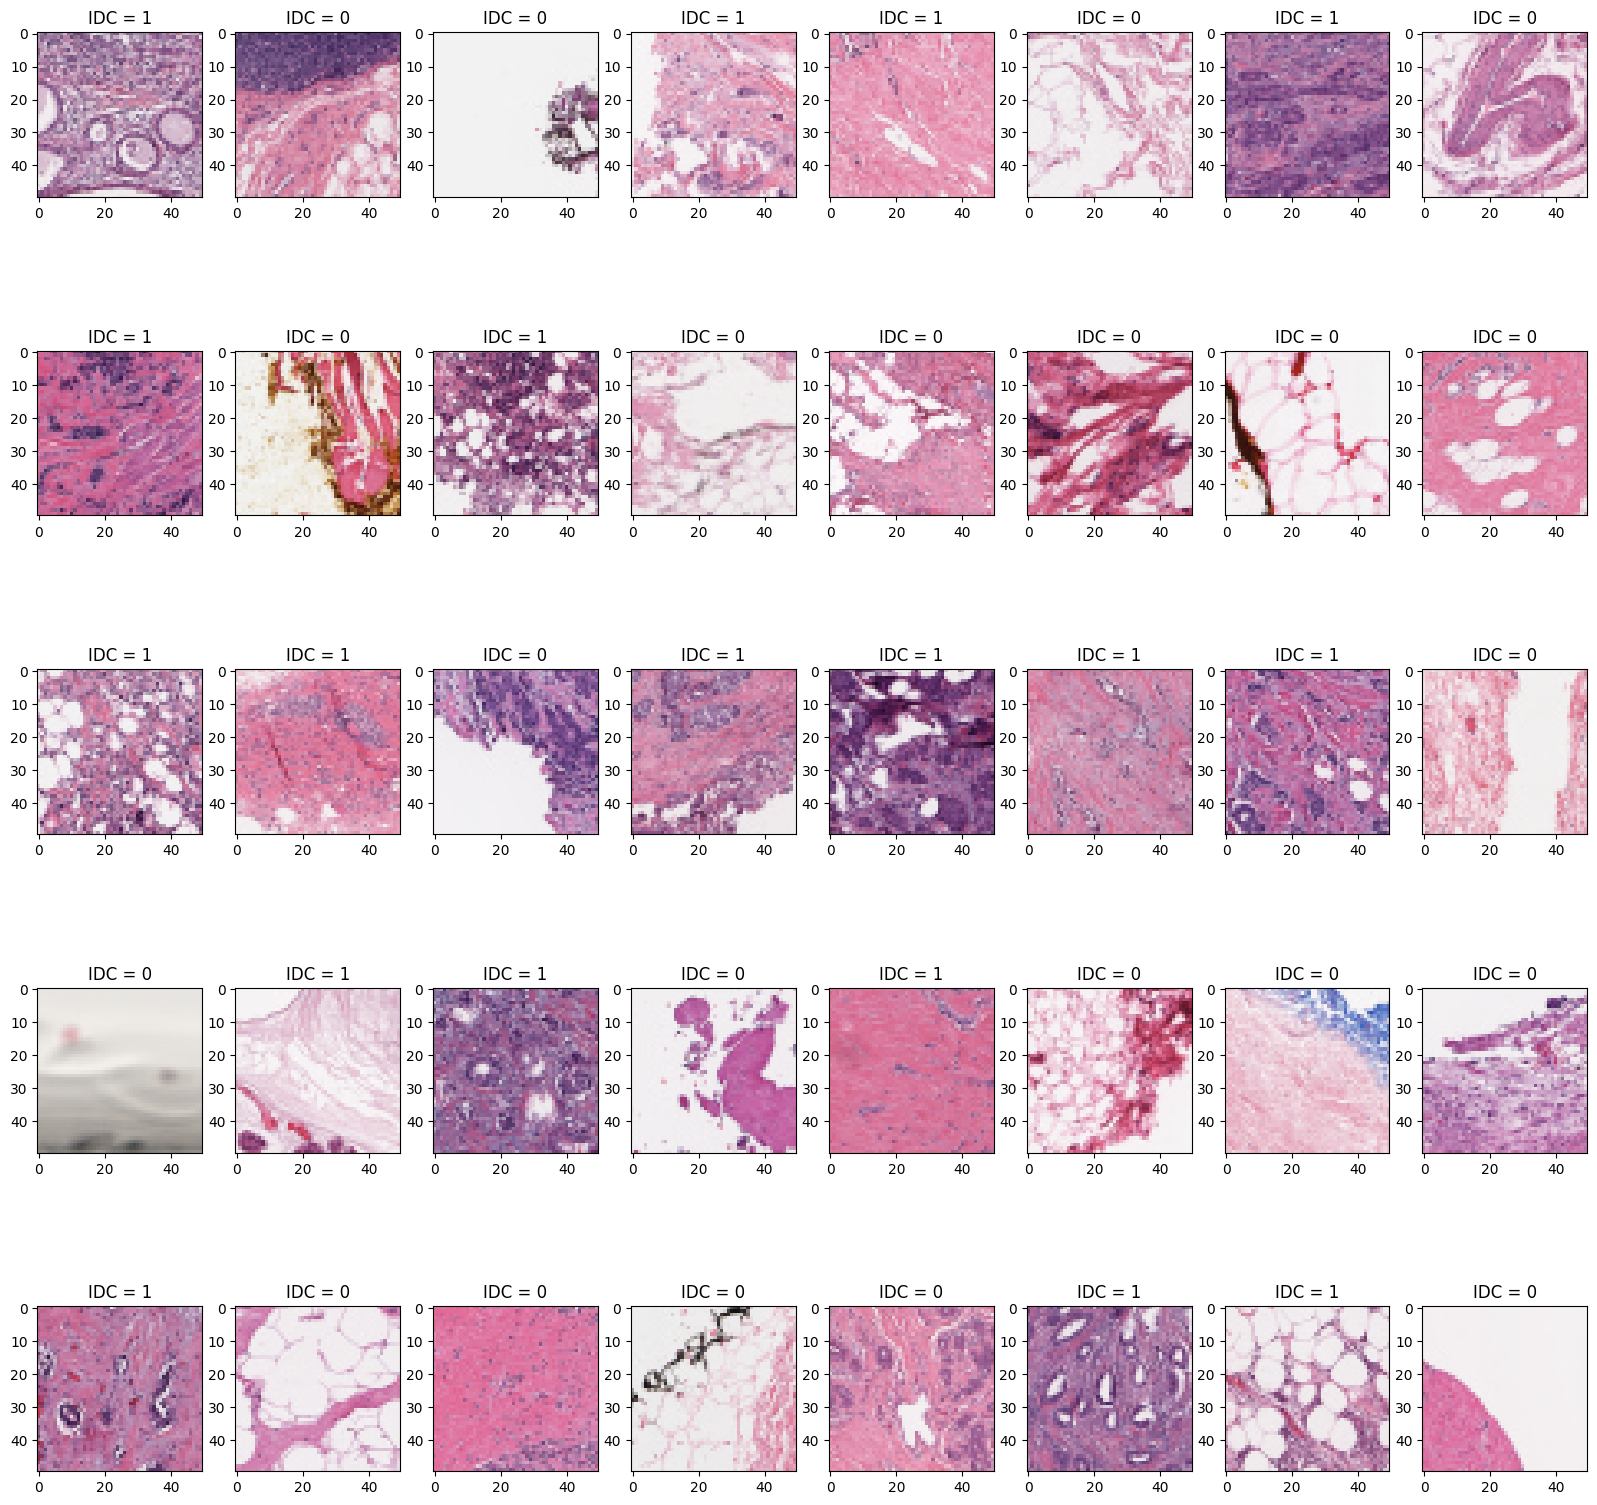

In [4]:
# Visualizing some of the images and their labels
imgs_0 = X[Y == 0]
imgs_1 = X[Y == 1]
plt.figure(figsize=(20,20))
for i in range(40):
  plt.subplot(5,8,i+1)
  plt.title('IDC = %d'%Y[i])
  plt.imshow(X[i])

In [5]:
# Print the shape and some statistics of the images
print('Y_images.shape =', Y.shape)
print('Y_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(Y.min(),Y.mean(), Y.std(), Y.max()))
print('')
print('X_images.shape =', X.shape)
print('X_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(X.min(),X.mean(), X.std(), X.max()))

Y_images.shape = (2774,)
Y_images.min/mean/std/max = 0.00/0.50/0.50/1.00

X_images.shape = (2774, 50, 50, 3)
X_images.min/mean/std/max = 3.00/185.47/47.17/255.00


In [6]:
print('Total number of images: {}'.format(len(X)))
print('Number of IDC(-) Images: {}'.format(np.sum(Y==0)))
print('Number of IDC(+) Images: {}'.format(np.sum(Y==1)))
print('Percentage of positive images: {:.2f}%'.format(100*np.mean(Y)))
print('Image shape (Width, Height, Channels): {}'.format(X[0].shape))


Total number of images: 2774
Number of IDC(-) Images: 1380
Number of IDC(+) Images: 1394
Percentage of positive images: 50.25%
Image shape (Width, Height, Channels): (50, 50, 3)


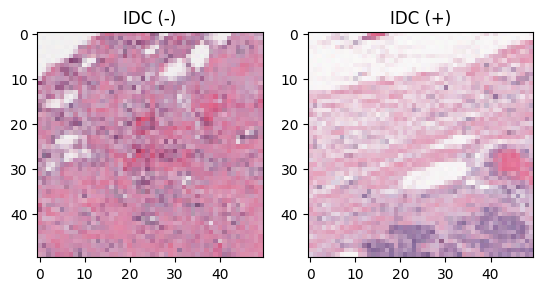

In [7]:
imgs0 = X[Y==0]
imgs1 = X[Y==1]

plt.subplot(1,2,1)
plt.title('IDC (-)')
plt.imshow(imgs0[100])
plt.subplot(1,2,2)
plt.title('IDC (+)')
plt.imshow(imgs1[100])

### 3. Data processing

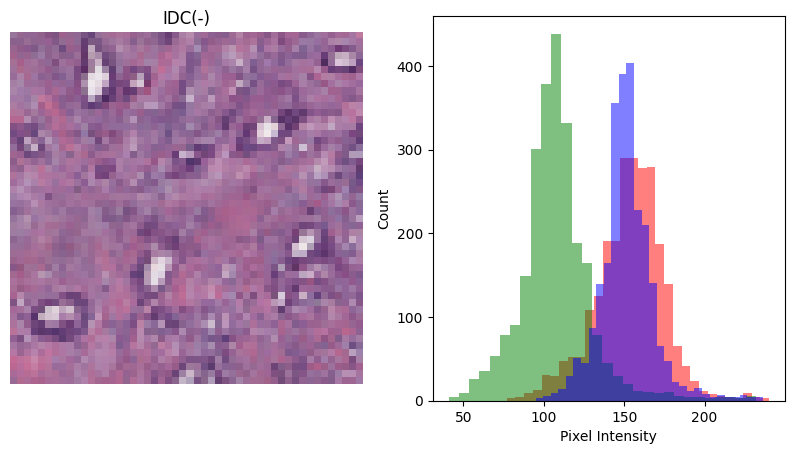

In [8]:
# Plotting a single image and its corresponding histogram
def plotHistogram(a):

    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n = 30
    plt.hist(a[:,:,0].flatten(), bins= n, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n, lw = 0, color='b', alpha=0.5);

plotHistogram(X[100])

#### Data split
Choose 20% Data for K-fold cross validation

In [9]:
# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train1, X_test1, Y_train1, Y_test1=X_train, X_test, Y_train, Y_test

X_train = X_train[0:30000]
Y_train = Y_train[0:30000]
X_test = X_test[0:30000]
Y_test = Y_test[0:30000]

#### Feature Scaling

In [10]:
# Standardize by dividing both the training set and the test set by 256
X_train = X_train / 256.0
X_test = X_test / 256.0

print("Training Data Shape:", X_train.shape, Y_train.shape)

print("Testing Data Shape:", X_test.shape, Y_test.shape)

Training Data Shape: (2219, 50, 50, 3) (2219,)
Testing Data Shape: (555, 50, 50, 3) (555,)


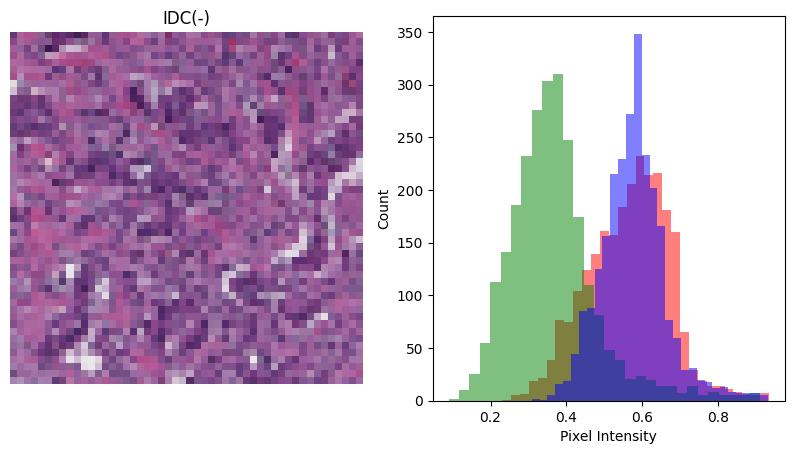

In [11]:
plotHistogram(X_train[100])

### 4. Machine Learning method

#### Characteristic flattening

In [12]:
# Flattening the data
import numpy as np
x_flatten_test = np.arange(135).reshape(5,3,3,3)

print(x_flatten_test)
print("The array dimension is：", x_flatten_test.shape)

[[[[  0   1   2]
   [  3   4   5]
   [  6   7   8]]

  [[  9  10  11]
   [ 12  13  14]
   [ 15  16  17]]

  [[ 18  19  20]
   [ 21  22  23]
   [ 24  25  26]]]


 [[[ 27  28  29]
   [ 30  31  32]
   [ 33  34  35]]

  [[ 36  37  38]
   [ 39  40  41]
   [ 42  43  44]]

  [[ 45  46  47]
   [ 48  49  50]
   [ 51  52  53]]]


 [[[ 54  55  56]
   [ 57  58  59]
   [ 60  61  62]]

  [[ 63  64  65]
   [ 66  67  68]
   [ 69  70  71]]

  [[ 72  73  74]
   [ 75  76  77]
   [ 78  79  80]]]


 [[[ 81  82  83]
   [ 84  85  86]
   [ 87  88  89]]

  [[ 90  91  92]
   [ 93  94  95]
   [ 96  97  98]]

  [[ 99 100 101]
   [102 103 104]
   [105 106 107]]]


 [[[108 109 110]
   [111 112 113]
   [114 115 116]]

  [[117 118 119]
   [120 121 122]
   [123 124 125]]

  [[126 127 128]
   [129 130 131]
   [132 133 134]]]]
The array dimension is： (5, 3, 3, 3)


#### length

In [13]:
x_flatten_testShape = x_flatten_test.shape[1]*x_flatten_test.shape[2]*x_flatten_test.shape[3]
x_flatten_testShape

27

#### Data flattening transformation

In [14]:
x_test_flatten_train = x_flatten_test.reshape(x_flatten_test.shape[0],
                                              x_flatten_testShape)

print(x_test_flatten_train)
print("The array dimension is：", x_test_flatten_train.shape)

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26]
 [ 27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
   45  46  47  48  49  50  51  52  53]
 [ 54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
   72  73  74  75  76  77  78  79  80]
 [ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
   99 100 101 102 103 104 105 106 107]
 [108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
  126 127 128 129 130 131 132 133 134]]
The array dimension is： (5, 27)


In [15]:
# 3 channels into 1 channel
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]

X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

#### Logistic regression cross validation

In [16]:
import time

def runLogisticRegression(a,b,c,d):

    model = LogisticRegression(solver='lbfgs', max_iter=3000)
    model.fit(a,b)
    kfold = model_selection.KFold(n_splits=10)

    accuracy = model_selection.cross_val_score(model, c,d,
                                               cv=kfold, scoring='accuracy')
    mean = accuracy.mean()
    stdev = accuracy.std()
    print('LogisticRegression - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')

start = time.time()
runLogisticRegression(X_trainFlat, Y_train, X_testFlat, Y_test)
end = time.time()
print('Total time cost is：',end-start, 's')

LogisticRegression - Training set accuracy: 0.7062987012987014 (0.04116934327183646)

Total time cost is： 73.52078652381897 s


#### 6 machine learning method

8min


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.706299 (0.041169)
RF: 0.762208 (0.045520)
KNN: 0.731688 (0.079536)
GNB: 0.720747 (0.056433)
DTC: 0.657760 (0.072531)


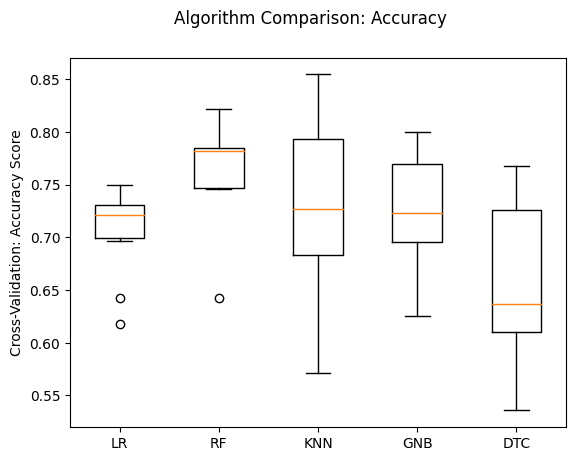

In [17]:
# Comparing multiple classifiers (Logistic Regression, Random Forest, KNN, Naive Bayes, and Decision Tree) using cross-validation
start = time.time()
(a,b,c,d)=(X_trainFlat, Y_train, X_testFlat, Y_test)
print('')
print('Compare Multiple Classifiers:')
print('')
print('K-Fold Cross-Validation Accuracy:')
print('')
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=3000)))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('DTC', DecisionTreeClassifier()))
resultsAccuracy = []
names = []

for name, model in models:
  model.fit(a, b)
  kfold = model_selection.KFold(n_splits=10)

  accuracy_results = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
  resultsAccuracy.append(accuracy_results)
  names.append(name)
  accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
  print(accuracyMessage)
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Accuracy')
ax = plt.subplot(111)
plt.boxplot(resultsAccuracy)
ax.set_xticklabels(names)
ax.set_ylabel('Cross-Validation: Accuracy Score')
plt.show()

end = time.time()

Ensemble Methods


In [18]:
# Using XGBoost classifier

import xgboost as xgb
X_train1 = X_train1.reshape(X_train1.shape[0], -1)
Y_train1 = Y_train1.reshape(Y_train1.shape[0], -1)
X_test1 = X_test1.reshape(X_test1.shape[0], -1)
Y_test1 = Y_test1.reshape(Y_test1.shape[0], -1)
model_2 = xgb.XGBClassifier()
model_2.fit(X_train1, Y_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [19]:
# Using KNeighborsClassifier and Logistic Regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
knn =  KNeighborsClassifier()

In [20]:
lr.fit(X_train1, Y_train1)

C:\Users\Arpana\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arpana\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [21]:
knn.fit(X_train1, Y_train1)

C:\Users\Arpana\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [22]:
# Using ensemble voting classifier with KNN, XGBoost, and Logistic Regression
from sklearn.ensemble import VotingClassifier
estimators=[('knn', knn),('model_2',model_2 ), ('lr', lr)]
ensemble = VotingClassifier(estimators, voting='hard')

In [23]:
ensemble

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('model_2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('lr', LogisticRegression())])

In [24]:
ensemble.fit(X_train1, Y_train1)

C:\Users\Arpana\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arpana\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\Arpana\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('model_2',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('lr', LogisticRegression())])

In [25]:
# Evaluating the ensemble classifier
EnsembleScore=ensemble.score(X_test1, Y_test1)

In [26]:
EnsembleScore

0.7657657657657657





GradientBoostingClassifier

In [27]:
# Using GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=300,
                                 learning_rate=0.05,
                                 random_state=100,
                                 max_features=5 )
gbc.fit(X_train1, Y_train1)
pred_y = gbc.predict(X_test1)
acc = accuracy_score(Y_test1, pred_y)

C:\Users\Arpana\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
acc

0.7927927927927928

XGBClassifier

In [29]:
pred_2 = model_2.predict(X_test1)
pred_2=pred_2.round()

In [30]:
from sklearn.metrics import accuracy_score

XGBClassifier=accuracy_score(Y_test1, pred_2)
XGBClassifier

0.7891891891891892

CNN_BreastCancerDetection

In [31]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
# importing sequential api
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
# importing layers from keras.layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [32]:
# count of no of labels present class wise
print(np.count_nonzero(Y == 1))
print(np.count_nonzero(Y == 0))

1394
1380


In [33]:
# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X/225.0, Y, test_size=0.2, stratify=Y)
X_train1, X_test1, Y_train1, Y_test1=X_train, X_test, Y_train, Y_test

X_train.shape, Y_train.shape

((2219, 50, 50, 3), (2219,))

In [34]:
# Convert class labels to one-hot encoded vectors
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

In [35]:
# callback function
class MetricsCheckpoint(Callback):
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

# learning curve
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle=True)[()]
    filt = ['acc']
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b',
                 label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100,
                    c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15',
                 color= 'r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

# This function gives the confusion matrix.
def plot_confusion_matrix(cm, classes,normalize=False,
                          title='Confusion matrix',cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)                                    # title
    plt.colorbar()                                      # color bar
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)        # x axis
    plt.yticks(tick_marks, classes)                     # y axis

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')